
# Temperate Ecohydrology


Here we discuss some simple problems in ecosystem hydrology, which, for ATS, means integrated surface and subsurface hydrology along with sources/sinks representing evapotranspiration and other land surface processes.

We describe a few different problems, including:

* **spinup** which aims to get the background soil water state comparable to antecedent water conditions
* **prescribed P - ET** which assumes that ET is known from data or another model
* **prescribed transpiration** where we assume that transpiration is known, and it is distributed to a rooting zone
* **Priestley-Taylor ET**: a simple model for total ET


Author: Ethan Coon

In [1]:
%matplotlib inline

In [2]:
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import ats_xdmf
import colors
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar
import pandas as pd

import h5py


## Spinup

For applications of temperate ecohydrology, spinup is all about getting antecedent soil moisture conditions correct.  There can be no expectation of getting reasonable hydrographs if the antecedent soil moisture field is wrong.

One way of beginning this process is to solve, to pseudo-steady state, the integrated hydrology problem with a constant source term that is given by the mean annual (or mean seasonal) precipitation minus evapotranspiration (P-ET) rate.  This can be solved for long times, using an adaptive timestep that grows as the solution approaches steady state.  This sets the mean background conditions for simulations with daily or other high-resolution inputs.

The first step is to provide an initial condition for that run which is hydrostatic with the water table at the surface.  Starting from fully saturated and drawing down to the steady state is faster and more efficient than starting from dry and filling up to the steady state.  To do this, we don't assume that this is a hillslope with fixed slope, but imagine that it is set by topography and therefore cannot be provided analytically.

To do this, we use the hydrostatic initial condition option.  Given that initial condition, we solve to steady state.  In this solve, we often use a too-large Manning's coefficient.  This slows up the surface water, which is safe to do because we're looking at such long time scales.  Surface water is still much faster than subsurface water, and as long as we aren't trying to get high frequency hydrographs correct, this makes for much faster simulations (with longer timestep sizes) with little loss in predictive power.

This run is for 20,000 days and is plotted below.  The image is a bit hard to see without exaggerating in the vertical -- a better way of seeing these runs is to open it in VisIt.

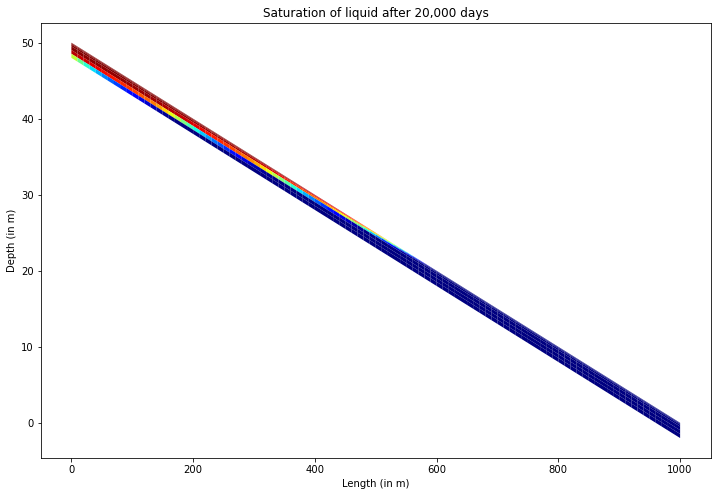

In [3]:
# plot the saturation at steady-state
directory = "spinup.demo"

vis = ats_xdmf.VisFile(directory, time_unit='d')
vis.loadMeshPolygons()

fig, ax = plt.subplots(1,1,figsize=(12,8))
def plot(i, ax):
    #ax = colorbar.make_axes(ax, 'right')[0]
    #cax.set_ylabel("saturation [-]")

    sat = vis.get("saturation_liquid", vis.cycles[i])
    poly = vis.getMeshPolygons(cmap='jet_r', linewidth=0)
    poly.set_array(sat)
    #oly.set_clim(0.4,1)
    ax.add_collection(poly)
    ax.set_title('Saturation of liquid after 20,000 days')
    ax.set_ylabel('Depth (in m)')
    ax.set_xlabel('Length (in m)')
    ax.axis('auto')

plot(0, ax)





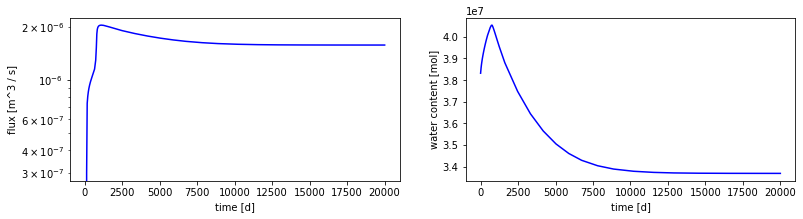

In [4]:
# plot the runoff and, more clearly, the total water content in the subsurface to see if we are at steadystate
fig, ax = plt.subplots(1,2, figsize=(13,3))

flux = pd.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
ax[0].semilogy(flux['time [s]'][:]/86400., flux['surface outlet flux'][:]/55000., 'b')
ax[0].set_xlabel('time [d]')
ax[0].set_ylabel('flux [m^3 / s]')

wc = pd.read_csv(os.path.join(directory, 'water_content.dat'), comment='#')
ax[1].plot(wc['time [s]'][:]/86400., wc[list(wc.keys())[1]][:], 'b')
ax[1].set_xlabel('time [d]')
ax[1].set_ylabel('water content [mol]')

plt.show()


## Prescribed P - ET

Often precipitation and evapotranspiration are known from either a preexisting land model run, remotely sensed or point data (e.g. eddy flux towers and weather stations) or other approaches.  Here we do a few examples to generate datasets for use in ATS and then drive simulations with this prescribed data.


### Data processing

Below is an example of how to generate, from raw data, the input files needed by ATS for P, E, and T for these examples.  Included here is output from a CLM 4.5 run for the Asu Basin outside Manaus, Brazil.  This run provides daily data of a variety of the water balance fluxes, including precipitation, evaporation, and transpiration.  We read this file and generate the two HDF5 forcing files for use in ATS in the prescribed P-ET examples.

In [5]:
data_fluxes = pd.read_csv('data/flux_output_w_fluxtowerR.txt',sep=' ')
data_fluxes

,atmospheric_rain(mm/s),surface_runoff(mm/s),subsurface_runoff(mm/s),infiltration(mm/s),interception(mm/s),ground_evaporation(mm/s),vegetation_evaporation(mm/s),vegetation_transpiration(mm/s),heat_flux_into_soil(W/m^2)
0,0.000500,8.530880e-05,0.000030,2.992950e-04,1.133880e-04,0.000002,9.545950e-06,9.558870e-08,-24.410700
1,0.000023,4.233740e-06,0.000031,1.352200e-05,5.249420e-06,0.000001,6.134040e-06,2.237700e-05,6.443230
2,0.000005,7.983280e-07,0.000034,4.425700e-07,1.049450e-06,0.000002,1.049450e-06,1.898540e-05,1.309580
3,0.000000,0.000000e+00,0.000035,-2.244530e-06,0.000000e+00,0.000002,0.000000e+00,1.994640e-05,3.089020
4,0.000162,3.122010e-05,0.000035,1.058450e-04,3.670030e-05,0.000002,2.252870e-05,1.311860e-05,0.384571
...,...,...,...,...,...,...,...,...,...
1456,0.000301,5.832140e-05,0.000017,1.838930e-04,6.838140e-05,0.000002,2.147030e-05,8.669930e-06,-3.079200
1457,0.000002,3.777780e-07,0.000019,6.314270e-05,5.257990e-07,0.000001,5.257990e-07,2.014490e-05,1.264350
1458,0.000002,3.795060e-07,0.000022,1.222840e-05,5.255860e-07,0.000002,5.255860e-07,1.914610e-05,-2.599310
1459,0.000125,2.381550e-05,0.000025,8.563180e-05,2.837010e-05,0.000002,1.529860e-05,1.023050e-05,-4.284620


In [6]:
# load the data
data = np.genfromtxt("data/flux_output_w_fluxtowerR.txt", names=True)



# note this read with column headers -- the file contains:
#print(data.dtype)

# daily data, converted to [s].  Note there are some units options in ATS, but it is easiest to 
# write data in SI units.
times = np.array(range(len(data)))
times = times * 86400.

print(len(times))

1461


[('atmospheric_rainmms', '<f8'), ('surface_runoffmms', '<f8'), ('subsurface_runoffmms', '<f8'), ('infiltrationmms', '<f8'), ('interceptionmms', '<f8'), ('ground_evaporationmms', '<f8'), ('vegetation_evaporationmms', '<f8'), ('vegetation_transpirationmms', '<f8'), ('heat_flux_into_soilWm2', '<f8')]


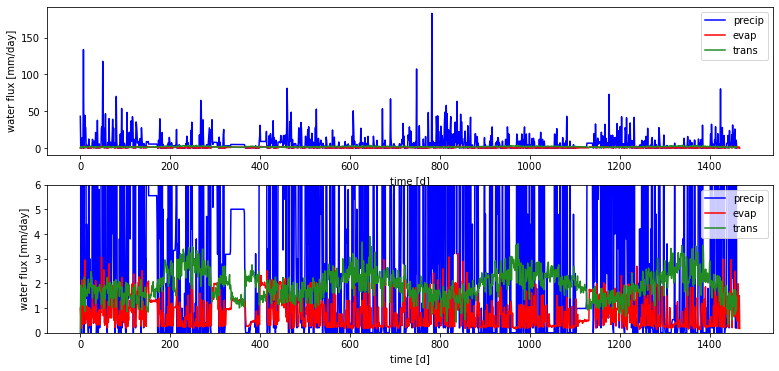

In [7]:
# load the data
data = np.genfromtxt("data/flux_output_w_fluxtowerR.txt", names=True)
# Four years of data is present!

# note this read with column headers -- the file contains:
print(data.dtype)

# daily data, converted to [s].  Note there are some units options in ATS, but it is easiest to 
# write data in SI units.
times = np.array(range(len(data)))
times = times * 86400.

# precip, evap, and trans are all in [mm/s], and so must be converted to [m/s] for use in ATS
# Subsurface water influx (Evaporation) = precipitation - (evap_vegetation + evap_ground)  
# Subsurface water influx (Evaporation + Transpiration) = precipitation - (evap_vegetation + evap_ground) - transpiration

precip = 1.e-3 * data['atmospheric_rainmms']
evap = 1.e-3 * (data['vegetation_evaporationmms'] + data['ground_evaporationmms'])
trans = 1.e-3 * data['vegetation_transpirationmms']

# plot the data
fig, axs = plt.subplots(2,1,figsize=(13,6))
def plot(ax):
    fac = 1.e3 * 86400 # Converting water fluxes from m/s --> mm/day
    ax.plot(times/86400., precip*fac, 'b', label='precip')
    ax.plot(times/86000., evap*fac, 'r', label='evap')
    ax.plot(times/86400., trans*fac, color='forestgreen', label='trans')
    ax.legend(loc='upper right')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('water flux [mm/day]')

plot(axs[0])
plot(axs[1])
axs[1].set_ylim(0, 6)

# write to disc
with h5py.File('data/prescribed_pet.h5','w') as fid:
    fid.create_dataset('time [s]', data=times)
    fid.create_dataset('precipitation [m s^-1]', data=precip)
    fid.create_dataset('evaporation [m s^-1]', data=evap)
    fid.create_dataset('transpiration [m s^-1]', data=trans)    
    fid.create_dataset('p_minus_et [m s^-1]', data=(precip - evap - trans))
    fid.create_dataset('p_minus_e [m s^-1]', data=(precip - evap))

plt.show()


### Daily forced simulations

Given the steady-state initial condition and the forcing data, we now run simulations forced by daily P-ET data.  Here we consider two choices -- first a run where P - ET is prescribed as a single entity as a function of time, and a second run where P - E is prescribed as a function of time while T is separated out.  

In the former case, the net water source is provided to the surface system (`prescribed_surface_evaporation.xml`).  This is often problematic.  Specifically, in most places, T can be order P, and pulling that much water from the surface isn't always possible --  <font color='red'> the top grid cell dries out and cannot get water to the surface fast enough.  Therefore a limiter must be applied to the ET to ensure it does not dry out a grid cell too much. </font>  This is especially problematic in 3D integrated hydrology simulations, where often the ET is calculated via a column model using an "average" depth to water table, which is significantly less than the depth to water table at, for instance, the top of a hillslope in a 3D run.

In the latter case, P-E is provided as a source to the surface system, while T is then distributed to a subsurface sink using a root profile for Plant Functional Type (PFT)-based vegetation (`prescribed_transpiration.xml`).  This is much more effective because the PFT rooting-depth based transpiration allows T to pull from depth, and has a native limiter on it based on soil moisture (or is it mafic potential?).  Note that the E may _still_ need to be limited, but typically, as E < P,T, this is less frequently a problem and typically full evaporation is taken and the limiter can be quite less of an issue.  

In these runs we did need a limiter for the surface ET case, but not for the distributed T case.

Note the limiters used here are quite naive -- <font color='red'> better limiters should be implemented before this approach is used for real science. </font>

Note that the hydrographs in the distributed case are drier, because ET was not limited and full transpiration was taken.

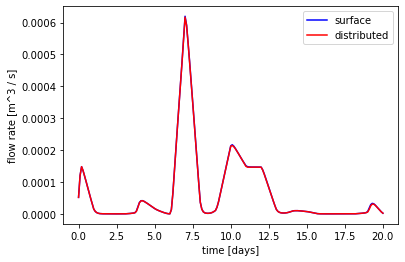

In [8]:
directory_p_et = 'prescribed_surface_evaporation.demo'
directory_p_e_t = 'prescribed_transpiration.demo'

# plot the hydrographs
fig, ax = plt.subplots(1,1)

def plot(ax, directory, name, color):
    flux = pd.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
    ax.plot(flux['time [d]'][:], flux['surface outlet flux'][:]/55000., color=color, label=name)

plot(ax, directory_p_et, 'surface', 'b')
plot(ax, directory_p_e_t, 'distributed', 'r')
ax.legend()
ax.set_xlabel('time [days]')
ax.set_ylabel('flow rate [m^3 / s]')
plt.show()

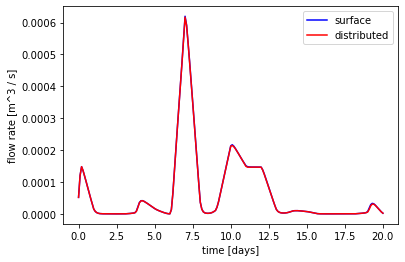

In [9]:
directory_p_et = 'prescribed_surface_evaporation.demo'
directory_p_e_t = 'prescribed_transpiration.demo'

# plot the hydrographs
fig, ax = plt.subplots(1,1)

def plot(ax, directory, name, color):
    flux = pd.read_csv(os.path.join(directory, 'surface_outlet_flux.dat'), comment='#')
    ax.plot(flux['time [d]'][:], flux['surface outlet flux'][:]/55000., color=color, label=name)

plot(ax, directory_p_et, 'surface', 'b')
plot(ax, directory_p_e_t, 'distributed', 'r')
ax.legend()
ax.set_xlabel('time [days]')
ax.set_ylabel('flow rate [m^3 / s]')
plt.show()

In [10]:
file_name = 'prescribed_surface_evaporation.demo'
input_filename = 'prescribed_surface_evaporation.xml'

In [11]:
# load the ATS solution
directory = f"./{file_name}/"
vis = ats_xdmf.VisFile(directory)
vis.loadMesh(columnar=True)

 - Lighter color signifies earlier time steps. 

VGC parameters: alpha = 0.00015, m = 0.8, w_res = 0

### RK - work

In [12]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    porosity = hdf.get('base_porosity.cell.0')
    print(porosity)

List of datasets in this file: 
 
 ['base_porosity.cell.0', 'capillary_pressure_gas_liq.cell.0', 'cell_volume.cell.0', 'darcy_velocity.cell.0', 'darcy_velocity.cell.1', 'darcy_velocity.cell.2', 'mass_density_liquid.cell.0', 'molar_density_liquid.cell.0', 'permeability.cell.0', 'porosity.cell.0', 'pressure.cell.0', 'relative_permeability.cell.0', 'saturation_gas.cell.0', 'saturation_liquid.cell.0', 'viscosity_liquid.cell.0', 'water_content.cell.0']


<HDF5 group "/base_porosity.cell.0" (21 members)>


In [13]:
def inputfiles_pddataframes(file_name,t):
    """
    The function is defined to read the input files from the ats simulation. 
    For each time instance, a dataframe can store the data.
 
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    t : The time instance at which the data is required.
    Ex: cell_volume.cell.0/{t} - here 0/0 - signifies the first directory (with data at t=0), 
    similary 0/1 - signifies the second directory (with data at t=1).
            
    Output parameters:
    
    data_results : pandas dataframe with all the key elements of the simulation.
    
    """
    
    with h5py.File(file_name,'r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0/{t}'))
        cell_volume = cell_volume_all.flatten()

        # Storing the variables/constants in a dataframe - Do we have a direct function to do this? 
        # Can we simplify the code?
        z = np.arange(0.0,80.0,0.1)
        data_results = pd.DataFrame(index=z,data=cell_volume,columns=['cell_volume'])

        mass_density_all = np.array(hdf.get(f'mass_density_liquid.cell.0/{t}'))
        mass_density = mass_density_all.flatten()
        data_results['mass_density [rho_l] [kg m^{-3}]'] = mass_density



        molar_density_all = np.array(hdf.get(f'molar_density_liquid.cell.0/{t}'))
        molar_density = molar_density_all.flatten()
        data_results['molar_density [n_l] [mol m^{-3}]'] = molar_density


        permeability_all = np.array(hdf.get(f'permeability.cell.0/{t}'))
        permeability = permeability_all.flatten()
        data_results['Absolute permeability [K] (m^{2})'] = permeability



        porosity_all = np.array(hdf.get(f'porosity.cell.0/{t}'))
        porosity = porosity_all.flatten()
        data_results['Porosity [phi] (-)'] = porosity

        pressure_all = np.array(hdf.get(f'pressure.cell.0/{t}'))
        pressure = pressure_all.flatten()
        data_results['Abs pressure [p_abs] [Pa]'] = pressure 
        # Water pressure or total pressure (Atm + water)? - Probably both

        relative_permeability_all = np.array(hdf.get(f'relative_permeability.cell.0/{t}'))
        relative_permeability = relative_permeability_all.flatten()
        data_results['Relative permeability [kr] [-]'] = relative_permeability


        saturation_gas_all = np.array(hdf.get(f'saturation_gas.cell.0/{t}'))
        saturation_gas = saturation_gas_all.flatten()
        data_results['Saturation of gas [s_g] [-]'] = saturation_gas


        saturation_liquid_all = np.array(hdf.get(f'saturation_liquid.cell.0/{t}'))
        saturation_liquid = saturation_liquid_all.flatten()
        data_results['Saturation of liquid [s_l] [-]'] = saturation_liquid


        #temperature_all = np.array(hdf.get(f'temperature.cell.0/{t}'))
        #temperature = temperature_all.flatten()
        #data_results['Temperature [T] [K]'] = temperature


        viscosity_liquid_all = np.array(hdf.get(f'viscosity_liquid.cell.0/{t}'))
        viscosity_liquid = viscosity_liquid_all.flatten()
        data_results['viscosity_liquid [v] Pas]'] = viscosity_liquid


        water_content_all = np.array(hdf.get(f'water_content.cell.0/{t}'))
        water_content = water_content_all.flatten()
        data_results['water_content [theta] mols'] = water_content
        
        return data_results

In [14]:
# Determining the time instances at which the data is stored

with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        print(time_period)
        # Time series stored in an irregular format! - 
        # ['0' '100' '103' '104' '105' '106' '107' '108' '109' '110' '111']

[  0 109 119 129 139 149 159 169 181 191 201 211 222  25  35  45  55  65
  77  87  97]


### Storing the data for all time instances

In [15]:
for i in time_period:
    # https://stackoverflow.com/questions/1060090/changing-variable-names-with-python-for-loops
    locals()["data_results_"+str(i)] = inputfiles_pddataframes(file_name=f'{file_name}/ats_vis_data.h5', t=i)

### Plotting the initial pressure:

In [16]:
data_results_0['Abs pressure [p_abs] [Pa]']

0.0      87980.380728
0.1      87983.753101
0.2      87989.960406
0.3      88007.089933
0.4      88067.137012
            ...      
79.5    105550.673603
79.6    107323.111613
79.7    110865.863668
79.8    115682.181767
79.9    120787.039096
Name: Abs pressure [p_abs] [Pa], Length: 800, dtype: float64

In [17]:
rho_avg = 1000 # kg m^{-3} - Provided by the developer 
g = 9.8006 # ms^{-2} - Provided by the user, g = (0,0,-9.8006m ms^{-2})
p_0 = 101325 # Pa

# Calculating the water pressure = p_abs -p_0
data_results_0['Water pressure [p_l] [Pa]'] = data_results_0['Abs pressure [p_abs] [Pa]'] - p_0

data_results_0['Pressure head [m]'] = data_results_0['Water pressure [p_l] [Pa]']/(rho_avg*g)

data_results_0['Elevation head [m]'] = data_results_0.index

data_results_0['Hydraulic head [m]'] = data_results_0['Pressure head [m]'] + data_results_0['Elevation head [m]']

data_results_0['Atmospheric pressure head [m]'] = 101325/(rho_avg*g)

data_results_0

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m]
0.0,0.3,1000.0,55000.0,1.000000e-12,0.400000,87980.380728,4.723243e-08,0.896826,0.103174,0.00089,680.945570,-13344.619272,-1.361612,0.0,-1.361612,10.338653
0.1,0.3,1000.0,55000.0,1.000000e-12,0.400000,87983.753101,4.734133e-08,0.896824,0.103176,0.00089,680.960635,-13341.246899,-1.361268,0.1,-1.261268,10.338653
0.2,0.6,1000.0,55000.0,1.000000e-12,0.400000,87989.960406,4.754250e-08,0.896820,0.103180,0.00089,1361.976807,-13335.039594,-1.360635,0.2,-1.160635,10.338653
0.3,1.2,1000.0,55000.0,1.000000e-12,0.400000,88007.089933,4.810257e-08,0.896808,0.103192,0.00089,2724.261160,-13317.910067,-1.358887,0.3,-1.058887,10.338653
0.4,2.4,1000.0,55000.0,1.000000e-12,0.400000,88067.137012,5.012448e-08,0.896767,0.103233,0.00089,5450.702704,-13257.862988,-1.352760,0.4,-0.952760,10.338653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79.5,1.2,1000.0,55000.0,1.000000e-12,0.400004,105550.673603,6.179775e+00,0.000000,1.000000,0.00089,26400.245894,4225.673603,0.431165,79.5,79.931165,10.338653
79.6,2.4,1000.0,55000.0,1.000000e-12,0.400005,107323.111613,6.179775e+00,0.000000,1.000000,0.00089,52800.725751,5998.111613,0.612015,79.6,80.212015,10.338653
79.7,4.8,1000.0,55000.0,1.000000e-12,0.400009,110865.863668,6.179775e+00,0.000000,1.000000,0.00089,105602.386788,9540.863668,0.973498,79.7,80.673498,10.338653
79.8,5.0,1000.0,55000.0,1.000000e-12,0.400014,115682.181767,6.179775e+00,0.000000,1.000000,0.00089,110003.810725,14357.181767,1.464929,79.8,81.264929,10.338653


### Since this is a hillslope problem, we extract the data along the first vertical section

In [18]:
data_results_1D = data_results_0.iloc[:8,:]
len(data_results_1D)

# Generating the z - coordinate
dx = 10 #m
dy = 1 #m
dz = (data_results_1D['cell_volume']/(dx * dy))/2 # Calculating the dz/2

data_results_1D['z'] = [0.015, 0.045, 0.09, 0.18, 0.36, 0.72, 1.21, 1.73] # Calculating the centers of each cell manually

data_results_1D.index = data_results_1D['z']

<ipython-input-18-72d046e110e1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_results_1D['z'] = [0.015, 0.045, 0.09, 0.18, 0.36, 0.72, 1.21, 1.73] # Calculating the centers of each cell manually


In [19]:
data_results_1D

,cell_volume,mass_density [rho_l] [kg m^{-3}],molar_density [n_l] [mol m^{-3}],Absolute permeability [K] (m^{2}),Porosity [phi] (-),Abs pressure [p_abs] [Pa],Relative permeability [kr] [-],Saturation of gas [s_g] [-],Saturation of liquid [s_l] [-],viscosity_liquid [v] Pas],water_content [theta] mols,Water pressure [p_l] [Pa],Pressure head [m],Elevation head [m],Hydraulic head [m],Atmospheric pressure head [m],z
z,,,,,,,,,,,,,,,,,
0.015,0.3,1000.0,55000.0,1.000000e-12,0.4,87980.380728,4.723243e-08,0.896826,0.103174,0.00089,680.945570,-13344.619272,-1.361612,0.0,-1.361612,10.338653,0.015
0.045,0.3,1000.0,55000.0,1.000000e-12,0.4,87983.753101,4.734133e-08,0.896824,0.103176,0.00089,680.960635,-13341.246899,-1.361268,0.1,-1.261268,10.338653,0.045
0.090,0.6,1000.0,55000.0,1.000000e-12,0.4,87989.960406,4.754250e-08,0.896820,0.103180,0.00089,1361.976807,-13335.039594,-1.360635,0.2,-1.160635,10.338653,0.090
0.180,1.2,1000.0,55000.0,1.000000e-12,0.4,88007.089933,4.810257e-08,0.896808,0.103192,0.00089,2724.261160,-13317.910067,-1.358887,0.3,-1.058887,10.338653,0.180
0.360,2.4,1000.0,55000.0,1.000000e-12,0.4,88067.137012,5.012448e-08,0.896767,0.103233,0.00089,5450.702704,-13257.862988,-1.352760,0.4,-0.952760,10.338653,0.360
0.720,4.8,1000.0,55000.0,1.000000e-12,0.4,88362.594342,6.155017e-08,0.896553,0.103447,0.00089,10924.010450,-12962.405658,-1.322613,0.5,-0.822613,10.338653,0.720
1.210,5.0,1000.0,55000.0,1.000000e-12,0.4,89782.080927,1.770482e-07,0.895206,0.104794,0.00089,11527.357764,-11542.919073,-1.177777,0.6,-0.577777,10.338653,1.210
1.730,5.4,1000.0,55000.0,1.000000e-12,0.4,93936.521068,1.025089e-05,0.882981,0.117019,0.00089,13901.914635,-7388.478932,-0.753880,0.7,-0.053880,10.338653,1.730


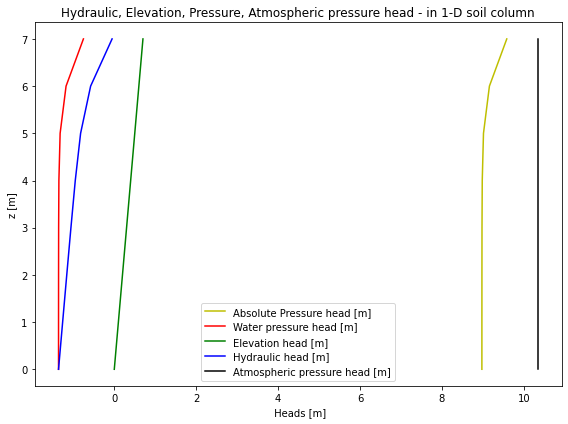

In [20]:
# To find the elevation where -ve pressure head begins
#z_drop = data_results_1D[data_results_1D['Pressure head [m]'].le(0)].index[0]

z = np.arange(0,8,1)

fig = plt.figure(figsize=(8,6))

plt.title('Hydraulic, Elevation, Pressure, Atmospheric pressure head - in 1-D soil column')
plt.plot(data_results_1D['Abs pressure [p_abs] [Pa]']/(rho_avg*g), z, 'y', label='Absolute Pressure head [m]')
plt.plot(data_results_1D['Pressure head [m]'], z, 'r', label='Water pressure head [m]')
plt.plot(data_results_1D['Elevation head [m]'], z, 'g', label='Elevation head [m]')
plt.plot(data_results_1D['Hydraulic head [m]'], z, 'b', label='Hydraulic head [m]')
plt.plot(data_results_1D['Atmospheric pressure head [m]'], z, 'k', label='Atmospheric pressure head [m]')
#plt.axhline(y=z_drop,color='k',linestyle='--',label=f'z_drop = {z_drop}')
plt.ylabel('z [m]')
plt.xlabel(' Heads [m]')
plt.legend()
plt.tight_layout()
plt.show()

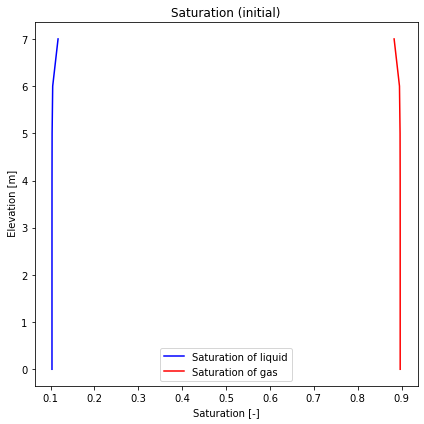

In [21]:
fig = plt.figure(figsize=(6,6))

plt.title('Saturation (initial)')
plt.plot(data_results_1D['Saturation of liquid [s_l] [-]'], z, 'b', label='Saturation of liquid')
plt.plot(data_results_1D['Saturation of gas [s_g] [-]'], z, 'r', label='Saturation of gas')

plt.xlabel('Saturation [-]')
plt.ylabel(' Elevation [m]')
plt.tight_layout()
plt.legend()
#plt.show()

* What is the sum of saturation of liquid and saturation of gas? Is'nt it 1? -It's okay

In [22]:
print(time_period.sort)

<built-in method sort of numpy.ndarray object at 0x7f2a1b818210>


In [23]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        print(time_period)

[  0  25  35  45  55  65  77  87  97 109 119 129 139 149 159 169 181 191
 201 211 222]


In [24]:
file_name

'prescribed_surface_evaporation.demo'

In [25]:
time_period[1:]

array([ 25,  35,  45,  55,  65,  77,  87,  97, 109, 119, 129, 139, 149,
       159, 169, 181, 191, 201, 211, 222])

### Defining a dataframe that extracts the data for a single variable for all time instances

In [26]:
def input_datavar(file_name, variable):
    """
    The function defined to extract a variable across all time instances.
    
    Parameters
    ------
    
    Input parameters:
    
    file_name : Provide the path to access the file name. 
    Ex: 'richards_steadystate.demo/ats_vis_data.h5'
    
    variable: Name of the variable in the dataset that you are interested in.
    Ex: 'cell_volume'
    
    Output parameters:
    
    data_var : pandas dataframe with the time series data of the variable.
    
    """
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
    
    with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        # Cell_volume
        z = np.arange(0.0, 80, 0.1)
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        data_var = pd.DataFrame(index=z,data=var_0,columns=[f'0'])
        
        for i in time_period[1:]:
            var_all = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var = var_all.flatten()
            
            data_var[f'{i}'] = var
    
    # Extracting only the data for the first vertical column of hillslope
    
    data_var = data_var.iloc[:8,:]
    
    # Changing the column values to actual column center
    
    z = [-0.015, -0.045, -0.09, -0.18, -0.36, -0.72, -1.21, -1.73] # Calculating the centers of each cell manually
    
    data_var.index = z
    
    # Reversing the data frame 
    
    
    
    return data_var

In [27]:
saturation_data.iloc[::-1]

NameError: name 'saturation_data' is not defined

In [28]:
np.arange(0,21,1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20])

In [29]:
### Accessing the variable at all time instances


variable = 'saturation_liquid'
saturation_data = input_datavar(file_name,variable)

saturation_data.columns = np.arange(0,21,1)

saturation_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
-0.015,0.103174,0.305911,0.204487,0.147949,0.327774,0.303511,0.224993,0.645267,0.362797,0.289958,...,0.450683,0.445277,0.304572,0.270757,0.262298,0.205737,0.161478,0.115369,0.309399,0.245062
-0.045,0.103176,0.318734,0.229575,0.182952,0.304091,0.307330,0.247340,0.639916,0.396809,0.292913,...,0.452909,0.445400,0.327992,0.274622,0.266831,0.229861,0.189655,0.159563,0.280468,0.264842
-0.090,0.103180,0.316344,0.248538,0.214846,0.264140,0.306932,0.265484,0.628908,0.432371,0.304985,...,0.456072,0.445634,0.353287,0.286177,0.274108,0.249861,0.221058,0.198273,0.235596,0.275984
-0.180,0.103192,0.254504,0.246474,0.227463,0.224885,0.285226,0.274007,0.596998,0.472458,0.337892,...,0.459958,0.446289,0.382828,0.314072,0.289635,0.271531,0.250849,0.233637,0.224498,0.267503
-0.360,0.103233,0.125250,0.163678,0.178452,0.184241,0.209772,0.233351,0.481133,0.506054,0.388673,...,0.457611,0.447788,0.412521,0.355757,0.321975,0.300975,0.283619,0.268627,0.256188,0.256653


In [30]:
### Accessing the variable at all time instances

variable = 'pressure'
pressure_data = input_datavar(file_name,variable)

pressure_data.columns = np.arange(0,21,1)

pressure_data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
-0.015,87980.380728,98359.314237,97471.510463,96209.747429,98479.916280,98345.150496,97721.588965,99505.423704,98647.534668,98261.240218,...,98978.833996,98961.058861,98351.438348,98129.020198,98064.839046,97488.501918,96646.922806,93665.703943,98379.543058,97920.133323
-0.045,87983.753101,98431.776649,97770.319053,97129.310388,98348.590283,98367.592974,97940.462927,99492.649419,98787.928923,98280.140693,...,98986.077966,98961.466552,98481.049736,98157.054230,98099.733682,97773.288634,97247.213735,96593.228545,98198.042252,98084.569772
-0.090,87989.960406,98418.658957,97950.995275,97605.022355,98079.158911,98365.275697,98089.487320,99466.229328,98917.490695,98353.871430,...,98996.296471,98962.240893,98604.658474,98236.532338,98153.370054,97962.505503,97677.875842,97382.910123,97831.135859,98166.752367
-0.180,88007.089933,98001.907097,97932.781076,97748.132382,97720.405657,98230.223579,98152.646381,99388.268281,99047.895679,98531.223131,...,99008.730955,98964.406833,98732.456878,98406.029210,98259.151651,98134.701342,97971.018188,97811.733850,97716.186431,98104.805515
-0.360,88067.137012,94898.303651,96705.973370,97042.931060,97152.941628,97541.661311,97808.864092,99074.372350,99147.578808,98755.997052,...,99001.236801,98969.349954,98847.049765,98615.964989,98449.300805,98329.969605,98219.465462,98113.234074,98015.835742,98019.645464


In [31]:
pressure_head_data = pressure_data/(10000)

In [32]:
pressure_head_data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
-0.015,8.798038,9.835931,9.747151,9.620975,9.847992,9.834515,9.772159,9.950542,9.864753,9.826124,...,9.897883,9.896106,9.835144,9.812902,9.806484,9.748850,9.664692,9.366570,9.837954,9.792013
-0.045,8.798375,9.843178,9.777032,9.712931,9.834859,9.836759,9.794046,9.949265,9.878793,9.828014,...,9.898608,9.896147,9.848105,9.815705,9.809973,9.777329,9.724721,9.659323,9.819804,9.808457
-0.090,8.798996,9.841866,9.795100,9.760502,9.807916,9.836528,9.808949,9.946623,9.891749,9.835387,...,9.899630,9.896224,9.860466,9.823653,9.815337,9.796251,9.767788,9.738291,9.783114,9.816675
-0.180,8.800709,9.800191,9.793278,9.774813,9.772041,9.823022,9.815265,9.938827,9.904790,9.853122,...,9.900873,9.896441,9.873246,9.840603,9.825915,9.813470,9.797102,9.781173,9.771619,9.810481
-0.360,8.806714,9.489830,9.670597,9.704293,9.715294,9.754166,9.780886,9.907437,9.914758,9.875600,...,9.900124,9.896935,9.884705,9.861596,9.844930,9.832997,9.821947,9.811323,9.801584,9.801965
-0.720,8.836259,8.838042,8.937976,9.115446,9.241693,9.355575,9.482931,9.734810,9.899591,9.889217,...,9.890625,9.895558,9.892098,9.879758,9.867035,9.856358,9.847222,9.839024,9.831545,9.825228
-1.210,8.978208,8.978209,8.978211,8.978233,8.978344,8.978760,8.981007,9.041714,9.763838,9.851963,...,9.874919,9.887197,9.892047,9.888641,9.881618,9.874389,9.867791,9.861835,9.856420,9.851500
-1.730,9.393652,9.393652,9.393652,9.393652,9.393653,9.393653,9.393653,9.393653,9.412207,9.624606,...,9.814131,9.863665,9.902356,9.930133,9.949356,9.963336,9.974120,9.982846,9.990129,9.996337


In [33]:
### Accessing the variable at all time instances

variable = 'relative_permeability'
relative_permeability = input_datavar(file_name,variable)

relative_permeability.columns = np.arange(0,21,1)
relative_permeability.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
-0.015,4.723243e-08,0.031196,0.003472,0.000284,0.043347,0.030027,0.006189,0.802295,0.069215,0.023998,...,0.179383,0.170354,0.030540,0.016980,0.014402,0.003608,0.000630,0.000007,0.032949,0.010013
-0.045,4.734133e-08,0.037982,0.006952,0.001651,0.030307,0.031901,0.010531,0.775160,0.103271,0.025233,...,0.183199,0.170556,0.043483,0.018259,0.015747,0.007002,0.002121,0.000570,0.020318,0.015146
-0.090,4.754250e-08,0.036646,0.010811,0.004709,0.014938,0.031702,0.015338,0.721550,0.150119,0.030741,...,0.188723,0.170940,0.061338,0.022481,0.018085,0.011125,0.005582,0.002850,0.008051,0.018725
-0.180,4.810257e-08,0.012280,0.010332,0.006593,0.006172,0.022110,0.018051,0.581940,0.219270,0.049960,...,0.195670,0.172019,0.088101,0.035406,0.023866,0.017231,0.011364,0.007681,0.006110,0.015953
-0.360,5.012448e-08,0.000036,0.000706,0.001380,0.001736,0.004071,0.007628,0.236811,0.292860,0.094235,...,0.191453,0.174507,0.122438,0.063319,0.039848,0.028827,0.021493,0.016303,0.012719,0.012842


In [34]:
data_fluxes = pd.read_csv('data/flux_output_w_fluxtowerR.txt',sep=' ')
data_fluxes

,atmospheric_rain(mm/s),surface_runoff(mm/s),subsurface_runoff(mm/s),infiltration(mm/s),interception(mm/s),ground_evaporation(mm/s),vegetation_evaporation(mm/s),vegetation_transpiration(mm/s),heat_flux_into_soil(W/m^2)
0,0.000500,8.530880e-05,0.000030,2.992950e-04,1.133880e-04,0.000002,9.545950e-06,9.558870e-08,-24.410700
1,0.000023,4.233740e-06,0.000031,1.352200e-05,5.249420e-06,0.000001,6.134040e-06,2.237700e-05,6.443230
2,0.000005,7.983280e-07,0.000034,4.425700e-07,1.049450e-06,0.000002,1.049450e-06,1.898540e-05,1.309580
3,0.000000,0.000000e+00,0.000035,-2.244530e-06,0.000000e+00,0.000002,0.000000e+00,1.994640e-05,3.089020
4,0.000162,3.122010e-05,0.000035,1.058450e-04,3.670030e-05,0.000002,2.252870e-05,1.311860e-05,0.384571
...,...,...,...,...,...,...,...,...,...
1456,0.000301,5.832140e-05,0.000017,1.838930e-04,6.838140e-05,0.000002,2.147030e-05,8.669930e-06,-3.079200
1457,0.000002,3.777780e-07,0.000019,6.314270e-05,5.257990e-07,0.000001,5.257990e-07,2.014490e-05,1.264350
1458,0.000002,3.795060e-07,0.000022,1.222840e-05,5.255860e-07,0.000002,5.255860e-07,1.914610e-05,-2.599310
1459,0.000125,2.381550e-05,0.000025,8.563180e-05,2.837010e-05,0.000002,1.529860e-05,1.023050e-05,-4.284620


[('atmospheric_rainmms', '<f8'), ('surface_runoffmms', '<f8'), ('subsurface_runoffmms', '<f8'), ('infiltrationmms', '<f8'), ('interceptionmms', '<f8'), ('ground_evaporationmms', '<f8'), ('vegetation_evaporationmms', '<f8'), ('vegetation_transpirationmms', '<f8'), ('heat_flux_into_soilWm2', '<f8')]


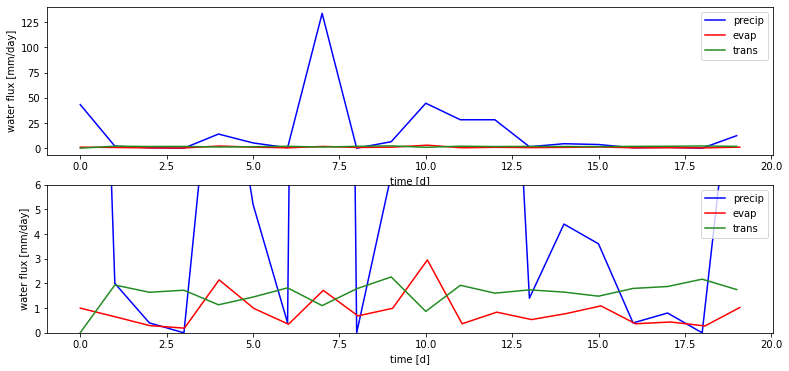

In [35]:
# load the data
data = np.genfromtxt("data/flux_output_w_fluxtowerR.txt", names=True)
# Four years of data is present!

# note this read with column headers -- the file contains:
print(data.dtype)

data = data[:20]
# daily data, converted to [s].  Note there are some units options in ATS, but it is easiest to 
# write data in SI units.
times = np.array(range(len(data)))
times = times * 86400.

# precip, evap, and trans are all in [mm/s], and so must be converted to [m/s] for use in ATS
# Subsurface water influx (Evaporation) = precipitation - (evap_vegetation + evap_ground)  
# Subsurface water influx (Evaporation + Transpiration) = precipitation - (evap_vegetation + evap_ground) - transpiration

precip = 1.e-3 * data['atmospheric_rainmms']
evap = 1.e-3 * (data['vegetation_evaporationmms'] + data['ground_evaporationmms'])
trans = 1.e-3 * data['vegetation_transpirationmms']

# plot the data
fig, axs = plt.subplots(2,1,figsize=(13,6))
def plot(ax):
    fac = 1.e3 * 86400 # Converting water fluxes from m/s --> mm/day
    ax.plot(times/86400., precip*fac, 'b', label='precip')
    ax.plot(times/86000., evap*fac, 'r', label='evap')
    ax.plot(times/86400., trans*fac, color='forestgreen', label='trans')
    ax.legend(loc='upper right')
    ax.set_xlabel('time [d]')
    ax.set_ylabel('water flux [mm/day]')

plot(axs[0])
plot(axs[1])
axs[1].set_ylim(0, 6)



plt.show()

Text(0.5, 0, 'Saturation (-)')

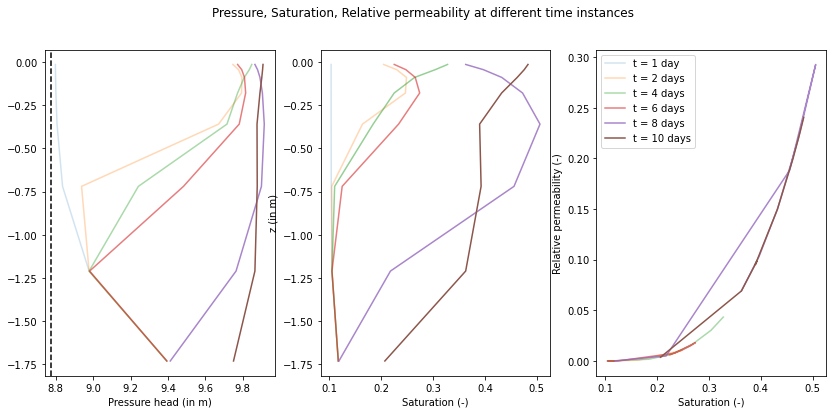

In [36]:
fig, (ax2, ax1, ax3) = plt.subplots(1, 3)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure, Saturation, Relative permeability at different time instances')

z = saturation_data.index

#saturation_data = saturation_data.iloc[::-1]


ax1.plot(saturation_data[0], z, alpha=0.2)
ax1.plot(saturation_data[2], z, alpha=0.3)
ax1.plot(saturation_data[4], z, alpha=0.5)
ax1.plot(saturation_data[6], z, alpha=0.6)
ax1.plot(saturation_data[8], z, alpha=0.8)
ax1.plot(saturation_data[10], z, alpha=1)
#ax1.plot(saturation_data[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation (-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2)
ax2.plot(pressure_head_data[2], z, alpha=0.3)
ax2.plot(pressure_head_data[4], z, alpha=0.4)
ax2.plot(pressure_head_data[6], z, alpha=0.6)
ax2.plot(pressure_head_data[8], z, alpha=0.8)
ax2.plot(pressure_head_data[10], z, alpha=1)
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.axvline(x=8.772805,color='k',linestyle='--',label='p-const = 8.77 m')
#ax2.legend()

ax3.plot(saturation_data[0], relative_permeability[0], alpha=0.2, label ='t = 1 day')
ax3.plot(saturation_data[2], relative_permeability[2], alpha=0.3, label ='t = 2 days')
ax3.plot(saturation_data[4], relative_permeability[4], alpha=0.4, label ='t = 4 days')
ax3.plot(saturation_data[6], relative_permeability[6], alpha=0.6, label ='t = 6 days')
ax3.plot(saturation_data[8], relative_permeability[8], alpha=0.8, label ='t = 8 days')
ax3.plot(saturation_data[10], relative_permeability[10], alpha=1, label ='t = 10 days')
#ax3.plot(saturation_data[200], relative_permeability[200], alpha=1, label ='t = 2 days')
ax3.legend()
ax3.set_ylabel('Relative permeability (-)')
ax3.set_xlabel('Saturation (-)')


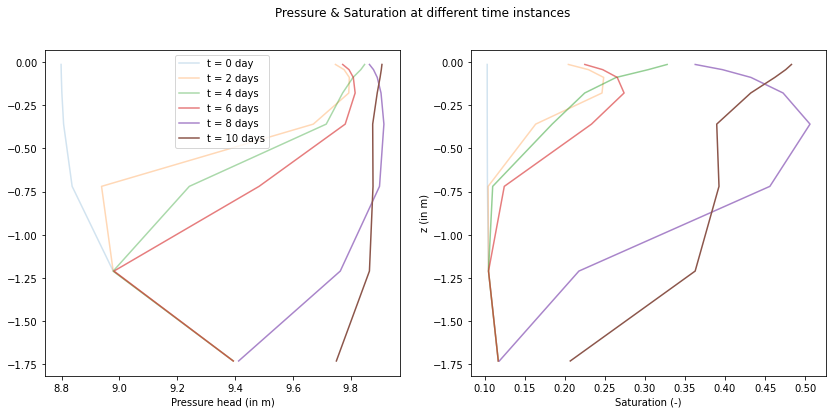

In [37]:
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure & Saturation at different time instances')

z = saturation_data.index

#saturation_data = saturation_data.iloc[::-1]

ax1.plot(saturation_data[0], z, alpha=0.2)
ax1.plot(saturation_data[2], z, alpha=0.3)
ax1.plot(saturation_data[4], z, alpha=0.5)
ax1.plot(saturation_data[6], z, alpha=0.6)
ax1.plot(saturation_data[8], z, alpha=0.8)
ax1.plot(saturation_data[10], z, alpha=1)
#ax1.plot(saturation_data[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation (-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0 day')
ax2.plot(pressure_head_data[2], z, alpha=0.3, label ='t = 2 days')
ax2.plot(pressure_head_data[4], z, alpha=0.4, label ='t = 4 days')
ax2.plot(pressure_head_data[6], z, alpha=0.6, label ='t = 6 days')
ax2.plot(pressure_head_data[8], z, alpha=0.8, label ='t = 8 days')
ax2.plot(pressure_head_data[10], z, alpha=1, label ='t = 10 days')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()


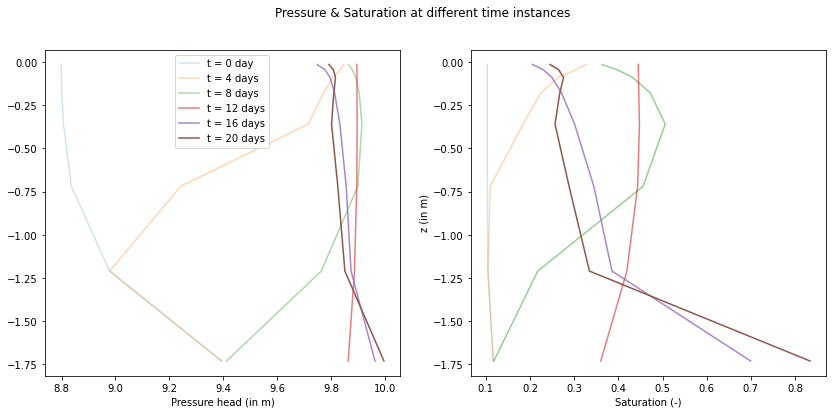

In [38]:
fig, (ax2, ax1) = plt.subplots(1, 2)
fig.set_size_inches(w=14,h=6)
fig.suptitle('Pressure & Saturation at different time instances')

z = saturation_data.index

#saturation_data = saturation_data.iloc[::-1]

ax1.plot(saturation_data[0], z, alpha=0.2)
ax1.plot(saturation_data[4], z, alpha=0.3)
ax1.plot(saturation_data[8], z, alpha=0.5)
ax1.plot(saturation_data[12], z, alpha=0.6)
ax1.plot(saturation_data[16], z, alpha=0.8)
ax1.plot(saturation_data[20], z, alpha=1)
#ax1.plot(saturation_data[200], z, alpha=1)
#ax1.legend()
ax1.set_ylabel('z (in m)')
ax1.set_xlabel('Saturation (-)')

ax2.plot(pressure_head_data[0], z, alpha=0.2, label ='t = 0 day')
ax2.plot(pressure_head_data[4], z, alpha=0.3, label ='t = 4 days')
ax2.plot(pressure_head_data[8], z, alpha=0.4, label ='t = 8 days')
ax2.plot(pressure_head_data[12], z, alpha=0.6, label ='t = 12 days')
ax2.plot(pressure_head_data[16], z, alpha=0.8, label ='t = 16 days')
ax2.plot(pressure_head_data[20], z, alpha=1, label ='t = 20 days')
#ax2.plot(pressure_head_data[200], z, alpha=1)
ax2.set_xlabel('Pressure head (in m)')
ax2.legend()



### Surface flow outputs

In [86]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
    ls = list(hdf.keys())
    print('List of datasets in this file: \n \n', ls)
    print('\n')
    ponded_depth = hdf.get('surface-ponded_depth.cell.0/100')
    print(ponded_depth)

List of datasets in this file: 
 
 ['surface-aspect.cell.0', 'surface-cell_volume.cell.0', 'surface-elevation.cell.0', 'surface-manning_coefficient.cell.0', 'surface-mass_density_liquid.cell.0', 'surface-molar_density_liquid.cell.0', 'surface-overland_conductivity.cell.0', 'surface-ponded_depth.cell.0', 'surface-ponded_depth_bar.cell.0', 'surface-pres_elev.cell.0', 'surface-pressure.cell.0', 'surface-relative_permeability.cell.0', 'surface-slope_magnitude.cell.0', 'surface-source_molar_density.cell.0', 'surface-surface_subsurface_flux.cell.0', 'surface-temperature.cell.0', 'surface-velocity.cell.0', 'surface-velocity.cell.1', 'surface-velocity.cell.2', 'surface-water_content.cell.0', 'surface-water_content_bar.cell.0']


<HDF5 dataset "100": shape (1, 1), type "<f8">


In [154]:
def input_datavarsurface(file_name, variable):
    """
        Define once more!
    """
    # To determine the time period and the list in which the dataframes 
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
    with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            
    data_var = data_var.transpose()
            #data_var = pd.DataFrame(index=time_period[i],data=var)
    
    return data_var

In [158]:
file_name = 'column.demo'
variable = 'surface-surface_subsurface_flux'
surface_ponded_depth = input_datavarsurface(file_name,variable)

#surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

,0
0,NaN
8,-0.166167
9,-0.166167
10,-0.166167
11,-0.166167
...,...
203,0.0
204,0.0
205,0.0
206,0.0


<AxesSubplot:>

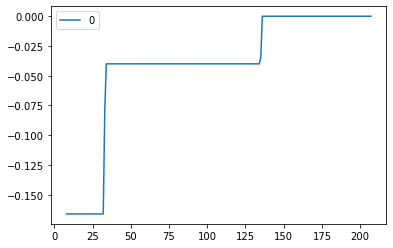

In [159]:
surface_ponded_depth.plot()

In [104]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/0'))
        var_0 = var_all_0.flatten()
        print(var_0)

[274.65]


In [137]:
data_var = pd.DataFrame(columns=time_period)
data_var[0] = var_all
data_var

,0,8,9,10,11,12,13,14,15,16,...,198,199,200,201,202,203,204,205,206,207
0,274.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [136]:
type(var_all)

numpy.ndarray

In [138]:
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:
        # Cell_volume
        cell_volume_all = np.array(hdf.get(f'surface-cell_volume.cell.0'))
        time_period = cell_volume_all.astype('int64')
        ### Sorting the dataframes 
        time_period.sort()
        data_var = pd.DataFrame(columns=time_period)
    
with h5py.File(f'{file_name}/ats_vis_surface_data.h5','r') as hdf:

        for i in time_period[1:]:
            var = np.array(hdf.get(f'{variable}.cell.0/{i}'))
            var_all = var.flatten()
            data_var[i] = var_all
            #data_var = pd.DataFrame(index=time_period[i],data=var)
print(data_var)     

   0       8       9       10      11      12      13      14      15   \
0  NaN  274.65  274.65  274.65  274.65  274.65  274.65  274.65  274.65   

      16   ...     198     199     200     201     202     203     204  \
0  274.65  ...  274.65  274.65  274.65  274.65  274.65  274.65  274.65   

      205     206     207  
0  274.65  274.65  274.65  

[1 rows x 201 columns]


In [141]:
type(data_var[0])

pandas.core.series.Series

In [95]:
variable = 'surface-water_content'
surface_ponded_depth = input_datavarsurface(file_name,variable)

surface_ponded_depth.columns = np.arange(0,201,1)
surface_ponded_depth

ValueError: Shape of passed values is (1, 1), indices imply (100, 1)

In [93]:
with h5py.File(f'{file_name}/ats_vis_data.h5','r') as hdf:
        z = np.arange(0.0, 10, 0.1)
        var_all_0 = np.array(hdf.get(f'{variable}.cell.0/100'))
        var_0 = var_all_0.flatten()
        print(var_0)

[None]
